In [50]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [51]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               746 non-null    object 
 1   SeasonNumber       746 non-null    int64  
 2   SeasonVersion      746 non-null    int64  
 3   Player             746 non-null    object 
 4   MatchId            746 non-null    object 
 5   Map                746 non-null    object 
 6   Category           746 non-null    object 
 7   Playlist           746 non-null    object 
 8   Input              746 non-null    object 
 9   Queue              746 non-null    object 
 10  PreCsr             746 non-null    int64  
 11  PostCsr            746 non-null    int64  
 12  Rank               746 non-null    int64  
 13  WasAtStart         746 non-null    int64  
 14  WasAtEnd           746 non-null    int64  
 15  WasInProgressJoin  746 non-null    int64  
 16  Mmr                2 non-n

In [52]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
## Per 10 Mins and Excess
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
df['ExcessKD'] = df['KD'] - round((df['ExpectedKills'] / df['ExpectedDeaths']),2)
## Lifetime
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100
df['LifetimeBodyPct'] = df['KillsBody'].cumsum() / df['Kills'].cumsum() *100
df['LifetimeMeleePct'] = df['KillsMelee'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeHSPct'] = df['KillsHeadshot'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeGrenadePct'] = df['KillsGrenade'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimePowerPct'] = df['KillsPower'].cumsum() / df['Kills'].cumsum() * 100

df['Map'] = df['Map'].str.replace(' - Ranked', '')

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'WasAtStart', 'WasAtEnd',
            'WasInProgressJoin', 'AssistsEmp', 'AssistsDriver', 'AssistsCallout', 'VehicleDestroys',
            'VehicleHijacks', 'Perfects', 'PreCsr', 'SeasonNumber', 'SeasonVersion'],axis=1)
dfr = df[df['Date']> '2023-01-01']
dfr = dfr[dfr['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['PostCsr'].replace(0, method='ffill')
dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                          (dfr['Outcome'].cumsum() + 
                           dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop(['Playlist', 'PostCsr'], axis=1).reset_index()
# dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('df.csv')
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               504 non-null    int64         
 1   Date                504 non-null    datetime64[ns]
 2   Map                 504 non-null    object        
 3   Category            504 non-null    object        
 4   Rank                504 non-null    int64         
 5   Outcome             504 non-null    int64         
 6   Accuracy            504 non-null    float64       
 7   DamageDone          504 non-null    int64         
 8   DamageTaken         504 non-null    int64         
 9   ShotsFired          504 non-null    int64         
 10  ShotsLanded         504 non-null    int64         
 11  ShotsMissed         504 non-null    int64         
 12  KD                  504 non-null    float64       
 13  KDA                 504 non-null    float64       

In [53]:
dfr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,504.0,442.136905,174.530472,140.000000,291.750000,441.500000,590.250000,745.000000
Rank,504.0,3.950397,2.152145,1.000000,2.000000,4.000000,5.000000,8.000000
Outcome,504.0,0.543651,0.498586,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,504.0,51.329702,5.381778,24.390000,48.272500,51.470000,54.412500,80.560000
DamageDone,504.0,5204.976190,1816.454660,347.000000,3928.000000,4945.000000,6412.250000,12673.000000
DamageTaken,504.0,4424.291667,1515.410378,276.000000,3448.750000,4233.500000,5352.750000,9962.000000
ShotsFired,504.0,236.371032,79.007633,16.000000,182.750000,228.000000,291.000000,517.000000
ShotsLanded,504.0,121.083333,41.862563,4.000000,94.000000,115.500000,148.000000,286.000000
ShotsMissed,504.0,115.287698,40.532030,7.000000,88.000000,112.000000,141.000000,261.000000
KD,504.0,1.277837,0.770440,0.000000,0.860000,1.130000,1.460000,10.000000


In [54]:
# dfr.tail()
# round(dfr.sort_values('LifetimeAcc', ascending=False),2)

In [55]:
# dfr.hist(bins=15, figsize=(18, 14))
# plt.tight_layout()
# plt.show()

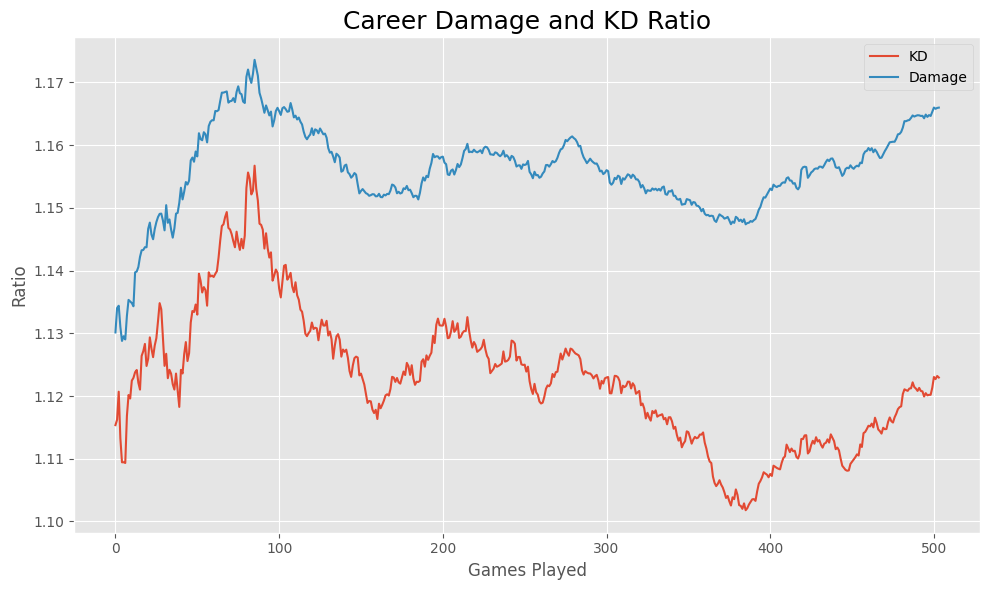

In [56]:
plt.figure(figsize=(10,6))
plt.plot(dfr['LifetimeKD'], label='KD' )
plt.plot(dfr['LifetimeDmgRatio'], label='Damage')
plt.title('Career Damage and KD Ratio', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/DamKD.png', dpi=300)
plt.show()

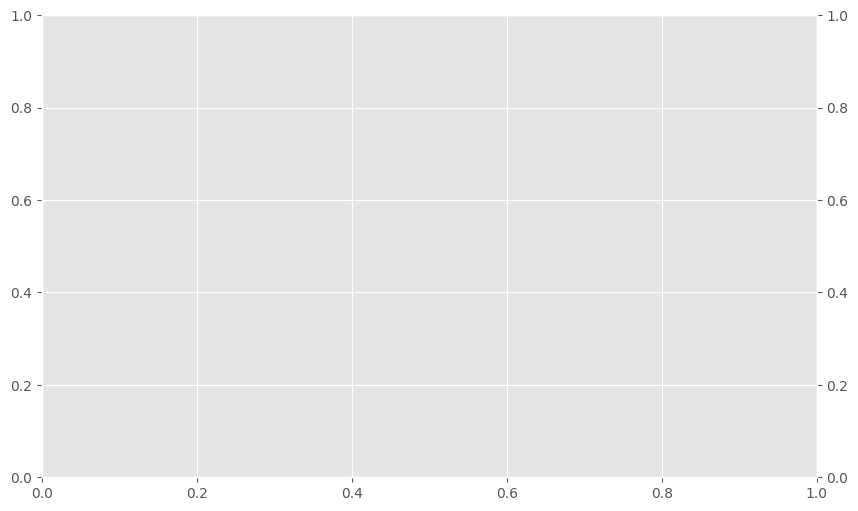

In [57]:
from IPython.display import HTML
from matplotlib import animation

plt.rcParams['animation.embed_limit'] = 300.0

dfr_date = dfr.index
dfr_kd = dfr['LifetimeKD']
dfr_dam = dfr['LifetimeDmgRatio']
dfr_csr = dfr['Csr']

# then assign df_date to x and df_close to y
x = dfr_date
y = dfr_kd
y2 = dfr_dam
y3 = dfr_csr

# calculate min and max x values + 1 and
# the min and max y values times scale factors
min_x = min(x)
max_x = max(x)
min_y = min(min(y), min(y2))
max_y = max(max(y), max(y2))
min_y3 = min(y3)
max_y3 = max(y3)

#########################################################################################
# generate and display animation line plot
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax2 = ax.twinx()

def animate(i):
    ax.cla() # clear the previous image
    ax2.cla()
    plt.title('KD/Damage Ratio and CSR over Time',fontsize=16)
    plt.xlabel('Game Played')
    plt.ylabel('Ratios/CSR')
    ax.plot(x[:i], y[:i], label='KD') # plot the line
    ax.plot(x[:i], y2[:i], label='Damage') # plot the line
    ax2.plot(x[:i], y3[:i], label='CSR', color='black')
    ax.set_xlim([0.99*min_x, 0.99*max_x]) # fix the x axis
    ax.set_ylim([0.99*min_y, 1.01*max_y]) # fix the y axis 
    ax2.set_xlim([0.99*min_x, 0.99*max_x])
    ax2.set_ylim(min_y3, 1.05*max_y3)
    ax.legend(loc='upper right')
#     ax2.legend(loc='lower right')
    
# anim = animation.FuncAnimation(fig, animate, frames = len(x), interval = 15)

# anim.save('Plots/KDDamCSR.gif', writer='imagemagick', fps=60)

# # Save the animation as HTML
# html_output = anim.to_html5_video()
# # Display the HTML animation in the Jupyter Notebook
# HTML(html_output)

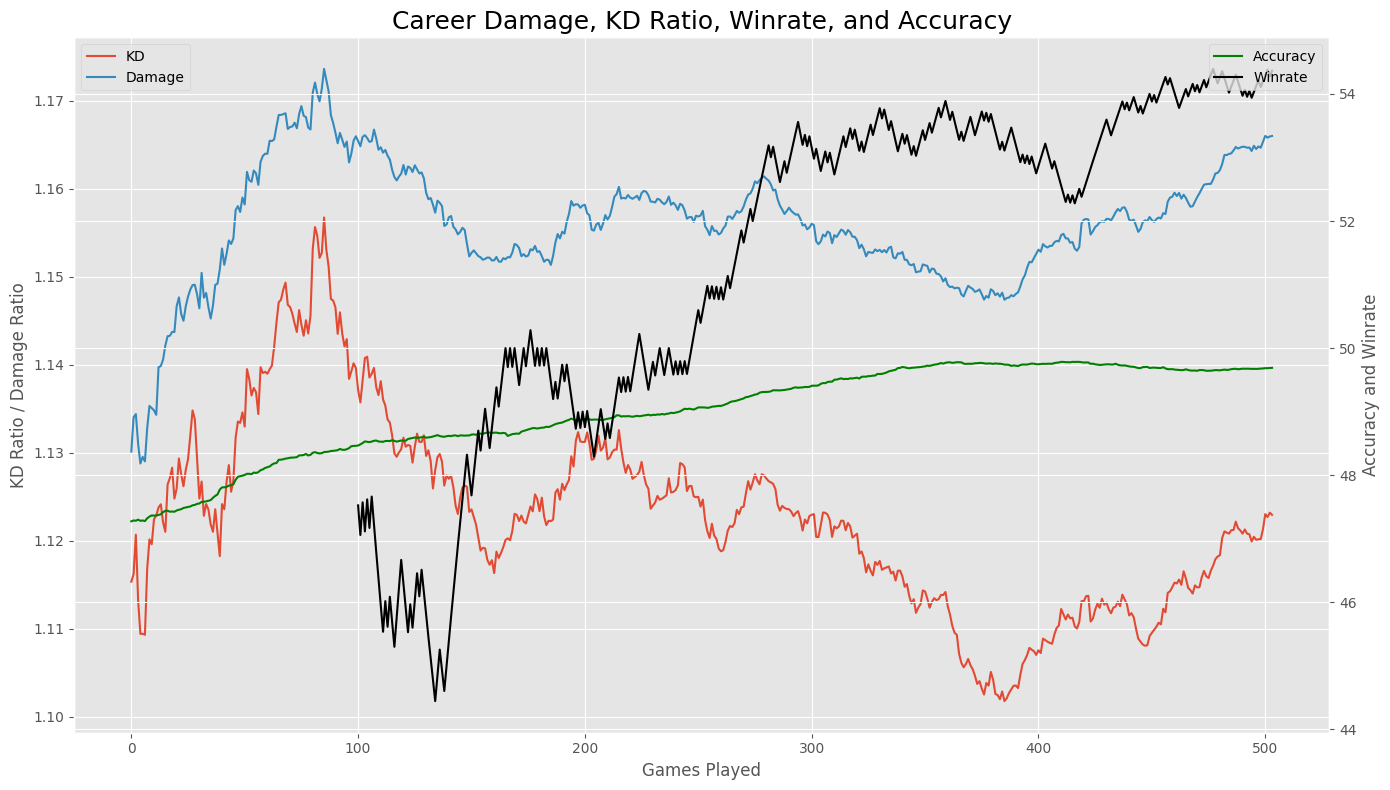

In [58]:
plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['LifetimeAcc'], color='green', label='Accuracy')
ax2.plot(dfr['LifetimeWinRate'][100:]*100, color='black', label='Winrate')
ax1.set_title('Career Damage, KD Ratio, Winrate, and Accuracy', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy and Winrate')

ax1.yaxis.grid(True)
ax2.yaxis.grid(True)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDWRAcc.png', dpi=300)
plt.show()

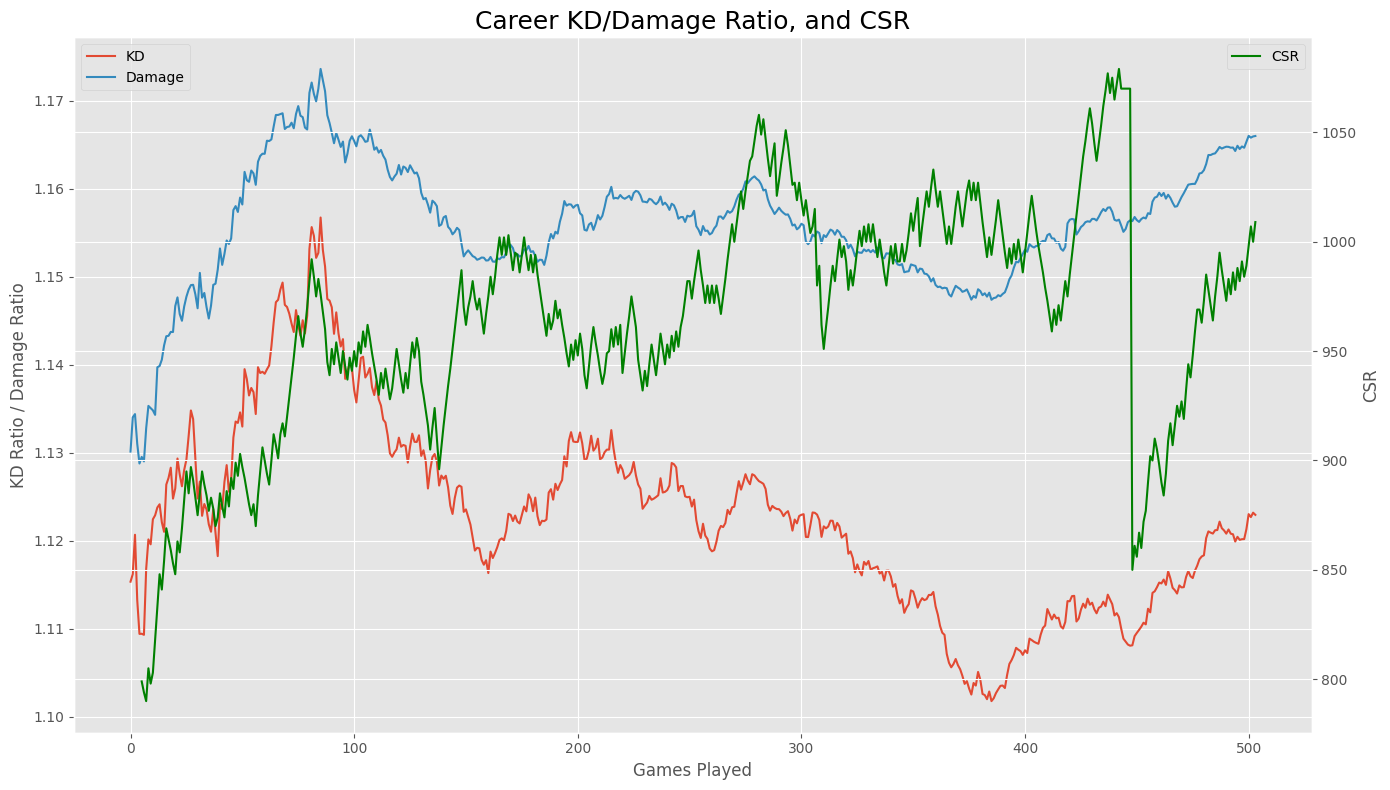

In [59]:
plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['Csr'][5:], label='CSR', color='green')
ax1.set_title('Career KD/Damage Ratio, and CSR', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('CSR')
# max_y_value = df['LifetimeAcc'].max()
# ax1.yaxis.grid(True)
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDCsr.png', dpi=300)
plt.show()

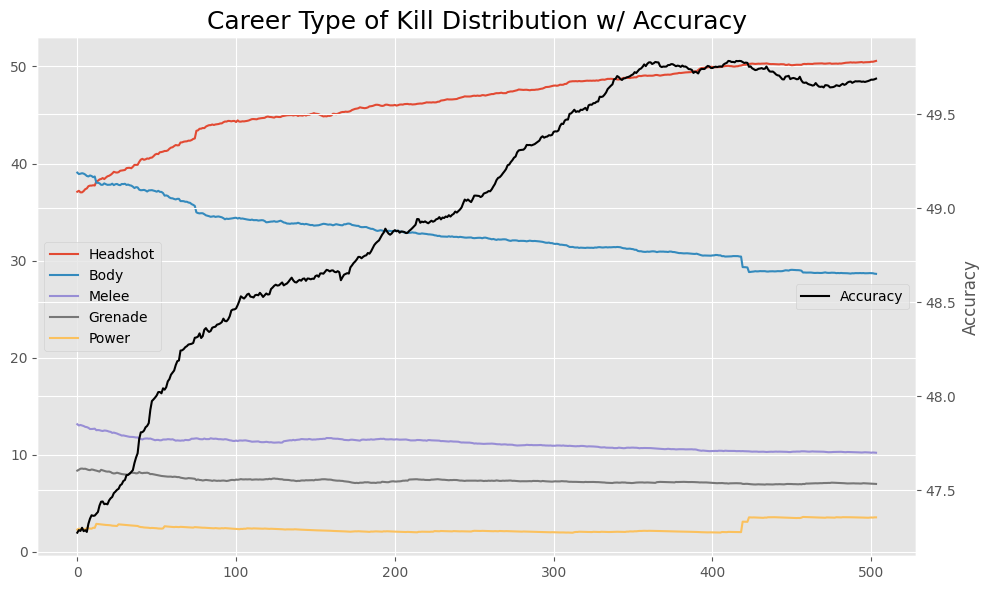

In [60]:
plt.figure(figsize=(10,6))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeHSPct'], label='Headshot')
ax1.plot(dfr['LifetimeBodyPct'], label='Body')
ax1.plot(dfr['LifetimeMeleePct'], label='Melee')
ax1.plot(dfr['LifetimeGrenadePct'], label='Grenade')
ax1.plot(dfr['LifetimePowerPct'], label='Power')
ax2.plot(dfr['LifetimeAcc'], label='Accuracy', color='black')
plt.title('Career Type of Kill Distribution w/ Accuracy', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Accuracy')
ax1.legend(loc='best')
ax2.legend(loc='right')
ax1.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/TypeKillAcc.png', dpi=300)
plt.show()

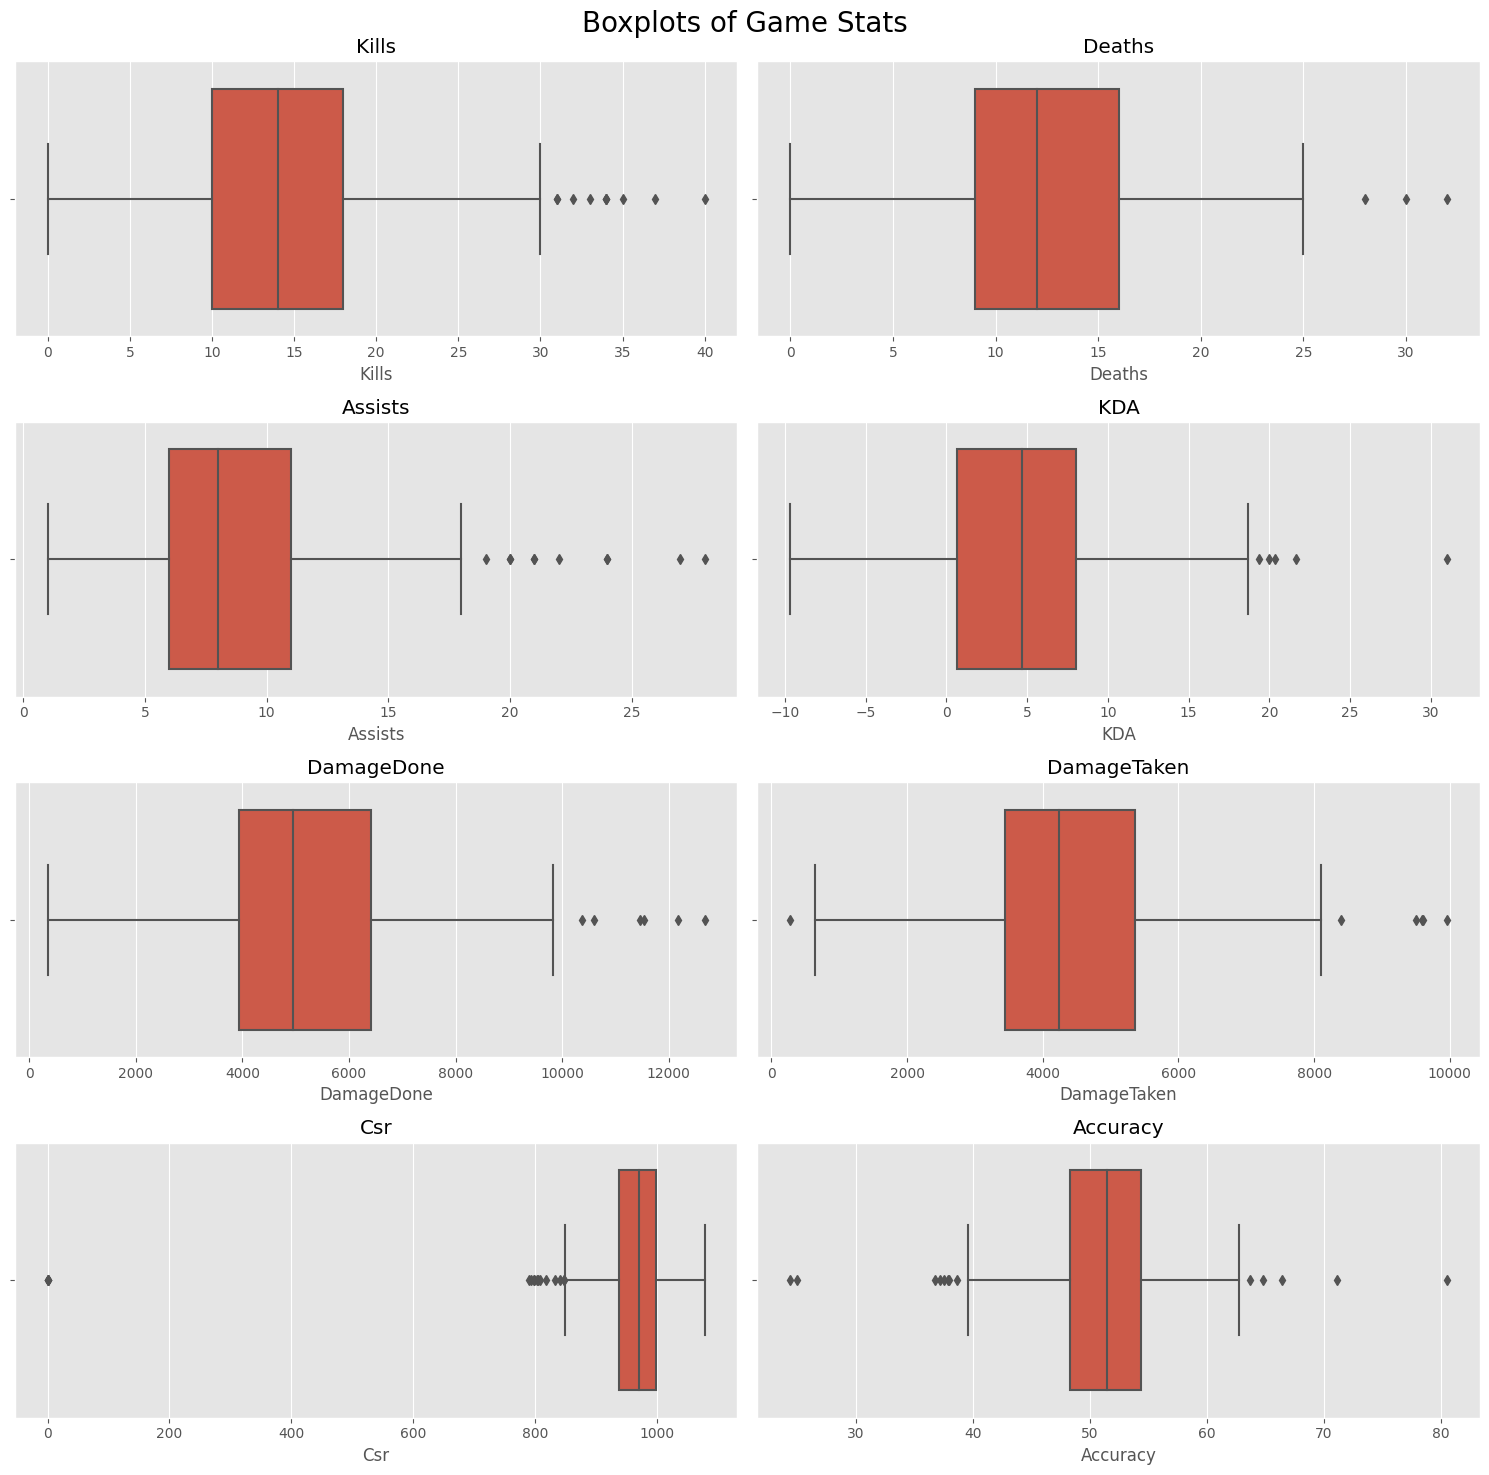

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle('Boxplots of Game Stats', fontsize=20)
plt.tight_layout()
plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


Last * Games stats  
Set mod to however many game you want to view 

In [74]:
# Last * Games

mod = 5
# dfmod = dfr.tail(mod)

dfmod = dfr[dfr['DamageTaken'] < dfr['DamageDone']]
# dfmod1 = dfr[dfr['DamageTaken'] > dfr['DamageDone']]

# print(dfmod.head())
print(f'Overall KD: {round(dfmod["Kills"].sum() / dfmod["Deaths"].sum(),2)}')
print(f"Accuracy: {round(dfmod['ShotsLanded'].sum() / dfmod['ShotsFired'].sum()*100,2)}")
print(f"Damage Ratio: {round(dfmod['DamageDone'].sum() / dfmod['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfmod['Outcome']==1).sum()}-{(dfmod['Outcome']==0).sum()}")
print(f"Max CSR: {dfmod['Csr'].max()}")
dfmod.sort_values('Kills', ascending=False).head(10)



392 - 112
Overall KD: 1.27
Accuracy: 51.87
Damage Ratio: 1.26
Win-Loss: 237-155
Max CSR: 1079


,index,Date,Map,Category,Rank,Outcome,Accuracy,DamageDone,DamageTaken,ShotsFired,...,LifetimeKD,LifetimeDmgRatio,LifetimeAcc,LifetimeBodyPct,LifetimeMeleePct,LifetimeHSPct,LifetimeGrenadePct,LifetimePowerPct,Csr,LifetimeWinRate
80,245,2023-11-04 03:12:06,Solitude,Strongholds,1,1,55.68,11536,6668,440,...,1.153137,1.170879,48.353591,34.784000,11.680000,43.648000,7.392000,2.496000,982,0.506173
310,513,2023-12-01 04:37:03,Solitude,Strongholds,5,0,58.12,12673,9598,468,...,1.121644,1.154712,49.502084,31.413613,10.934929,48.436799,7.225131,1.989529,951,0.527331
338,543,2023-12-08 03:04:13,Streets,Oddball,8,0,58.95,12172,9496,458,...,1.116607,1.152649,49.685590,31.398935,10.695262,48.696384,7.134847,2.074572,980,0.530973
392,610,2024-01-12 01:58:00,Streets,Oddball,6,0,56.86,9835,7153,408,...,1.104783,1.148890,49.733628,30.593093,10.447948,49.762262,7.157157,2.039540,988,0.529262
103,269,2023-11-06 01:41:02,Streets,Oddball,8,0,55.74,9183,7717,357,...,1.140758,1.166059,48.531295,34.325794,11.480103,44.317206,7.500716,2.376181,949,0.471154
410,629,2024-01-16 04:35:00,Empyrean,CTF 3 Captures,6,0,55.29,8651,5940,331,...,1.112254,1.154715,49.783641,30.421723,10.404902,50.066082,7.040731,2.066563,973,0.525547
501,742,2024-02-22 01:19:28,Streets,Oddball,4,1,49.50,10596,9605,497,...,1.122700,1.165784,49.683768,28.705007,10.245325,50.482606,7.027951,3.539111,1007,0.543825
40,191,2023-10-30 02:11:48,Recharge,King of the Hill,3,1,52.67,8431,6003,393,...,1.124174,1.153200,47.807943,37.253255,11.633767,40.403192,8.147837,2.561949,885,0.487805
46,197,2023-10-30 03:30:33,Aquarius,CTF 5 Captures,6,0,60.56,9835,6512,464,...,1.131723,1.157562,47.927436,37.253323,11.679420,40.596053,8.014499,2.456706,887,0.468085
181,355,2023-11-09 06:34:56,Recharge,King of the Hill,1,1,50.55,8335,7880,362,...,1.124908,1.152338,48.747116,33.464223,11.561955,45.702443,7.177138,2.094241,994,0.500000


In [80]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

print('Overall')
print(f'Overall KD: {round(dfr["Kills/10Min"].sum() / dfr["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfr['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfr['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfr['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfr['ShotsLanded'].sum() / dfr['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfr['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfr['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfr['DamageDone'].sum() / dfr['DamageTaken'].sum(),2)}")
print(f"Dmg Done <> Taken: {len(dfmod)}-{len(dfmod1)}")
print(f"Win-Loss: {(dfr['Outcome']==1).sum()}-{(dfr['Outcome']==0).sum()}")
print('----------------------------')
print('Wins')
print(f'Overall KD: {round(dfw["Kills/10Min"].sum() / dfw["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfw['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfw['ShotsLanded'].sum() / dfw['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Wins: {(dfw['Outcome']==1).sum()}")
print('----------------------------')
print('Losses')
print(f'Overall KD: {round(dfl["Kills/10Min"].sum() / dfl["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfl['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfl['ShotsLanded'].sum() / dfl['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Losses: {(dfl['Outcome']==0).sum()}")

Overall
Overall KD: 1.15
Average Kills: 13.8
Average Deaths: 12.01
Average Assists: 7.99
Average Accuracy: 51.23
Average Damage Done: 5205
Average Damage Taken: 4424
Damage Ratio: 1.18
Dmg Done <> Taken: 392-112
Win-Loss: 274-230
----------------------------
Wins
Overall KD: 1.33
Average Kills: 14.28
Average Deaths: 10.75
Average Assists: 8.46
Average Accuracy: 51.36
Average Damage Done: 5045
Average Damage Taken: 4086
Damage Ratio: 1.23
Wins: 274
----------------------------
Losses
Overall KD: 0.98
Average Kills: 13.23
Average Deaths: 13.52
Average Assists: 7.44
Average Accuracy: 51.08
Average Damage Done: 5395
Average Damage Taken: 4827
Damage Ratio: 1.12
Losses: 230


In [64]:
# Ranks, 1 = Top Winner, 5 = Top Loser
g1 = dfr[dfr['Rank'] == 1].value_counts().count()
g5 = dfr[dfr['Rank'] == 5].value_counts().count()
g15 = round((g1 + g5) / len(dfr)*100,2)


print('Games Ranked 1:',g1)
print('Games Ranked 5:',g5)
print('MVP %:',g15 )

Games Ranked 1: 107
Games Ranked 5: 122
MVP %: 45.44


## Scorigami
Inspired by NFL, tracks unique statlines and counts if theyve occured before, only shows duplicate records instead of unique

In [65]:
# Create a new column for the combined score in the desired format
dfGami = pd.DataFrame()
dfGami['Kills'] = dfr['Kills']
dfGami['Deaths'] = dfr['Deaths']
dfGami['Assists'] = dfr['Assists']
dfGami['Scorigami'] = dfr['Kills'].astype(str) + '-' + dfr['Deaths'].astype(str) + '-' + dfr['Assists'].astype(str)

# Get unique scorigami scores
scorigami_list = dfGami['Scorigami'].unique()

dfGami = dfGami.sort_values(by=['Kills', 'Deaths', 'Assists'], ascending=False)
print(dfGami.head())
dfGami.to_csv('Scorigami.csv')

     Kills  Deaths  Assists Scorigami
80      40      17       24  40-17-24
310     37      28       17  37-28-17
338     35      25       18  35-25-18
103     34      23        7   34-23-7
392     34      21       15  34-21-15


In [66]:
gamiPiv = dfGami.pivot_table(index='Scorigami', aggfunc='size')

gamiPiv = gamiPiv.sort_index()

print("Records with >1 SS: " ,gamiPiv[gamiPiv.values>1].count())
print(gamiPiv[gamiPiv.values>1].sort_index(ascending=True).sort_values(ascending=False))


Records with >1 SS:  33
Scorigami
15-8-7      3
7-12-7      3
6-11-8      3
16-11-8     2
8-11-5      2
7-8-7       2
7-12-4      2
7-11-6      2
24-19-6     2
21-18-9     2
20-12-6     2
19-18-10    2
17-17-3     2
17-16-11    2
17-15-9     2
17-14-5     2
10-10-3     2
10-5-7      2
15-13-8     2
15-11-8     2
15-11-10    2
15-10-14    2
14-14-7     2
14-11-8     2
14-10-11    2
13-14-10    2
13-11-9     2
12-10-6     2
11-8-7      2
11-12-7     2
10-7-5      2
10-7-1      2
9-11-3      2
dtype: int64


In [67]:
dfrc = dfr.groupby('Category').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
round(dfrc.sort_values('Length%', ascending=False),2)

,LengthMinutes,Count,Length%,Count%
Category,,,,
Slayer,1016.37,118,19.33,23.41
Strongholds,937.50,79,17.83,15.67
Oddball,884.33,74,16.82,14.68
King of the Hill,764.27,70,14.53,13.89
CTF 3 Captures,760.80,70,14.47,13.89
Extraction,611.85,70,11.64,13.89
CTF 5 Captures,283.10,23,5.38,4.56


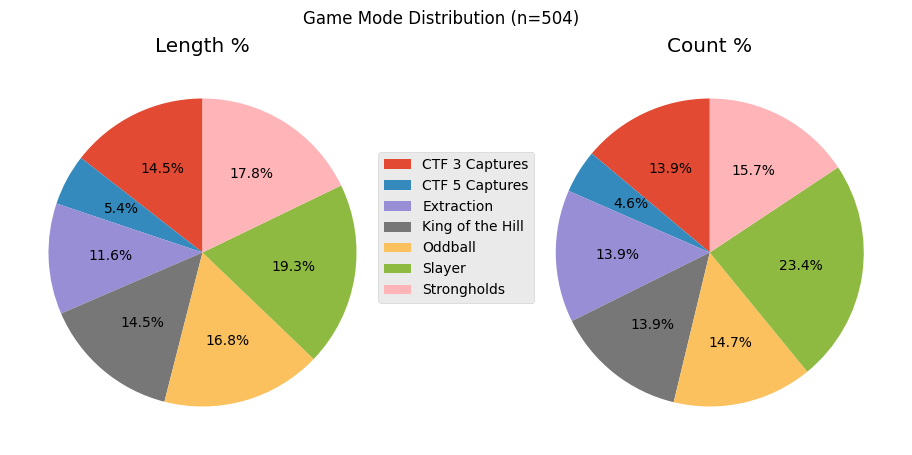

In [68]:
import matplotlib.pyplot as plt

labels = dfrc.index.get_level_values('Category').tolist()
sizes_length = dfrc['Length%'].tolist()
sizes_count = dfrc['Count%'].tolist()
totalcount = dfrc['Count'].sum()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Create a subplot with 1 row and 2 columns
ax[0].pie(sizes_length, labels=None, autopct='%1.1f%%', startangle=90)
ax[1].pie(sizes_count, labels=None, autopct='%1.1f%%', startangle=90)
fig.suptitle(f'Game Mode Distribution (n={totalcount})')
ax[0].set(aspect="equal", title='Length %')
ax[1].set(aspect="equal", title='Count %')
fig.legend(labels, loc="center")
plt.savefig('Plots/ModeDistro.png', dpi=300)
plt.show()

In [69]:
dfrc = dfr.groupby(['Category','Map']).agg({'Category': 'count', 'LengthMinutes': 'sum', 'Outcome': 'mean'})
dfrc.rename(columns={'Category': 'Count', 'LengthMinutes': 'LengthHours'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthHours']/60,2)
dfrc['Outcome'] = round(dfrc['Outcome'],2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['Length%'] = round(dfrc['LengthHours'] / dfrc['LengthHours'].sum() * 100,2)
dfrc = dfrc.sort_values(['Length%'], ascending=False)
dfrc

Count  LengthHours  Outcome  Count%  Length%
Category         Map                                                    
Strongholds      Solitude      36         7.66     0.39    7.14     8.74
King of the Hill Recharge      34         6.58     0.53    6.75     7.51
Oddball          Streets       29         6.00     0.55    5.75     6.84
Slayer           Solitude      36         5.29     0.58    7.14     6.03
                 Aquarius      36         5.13     0.58    7.14     5.85
CTF 3 Captures   Empyrean      26         4.82     0.46    5.16     5.50
Extraction       Streets       33         4.74     0.61    6.55     5.41
CTF 5 Captures   Aquarius      23         4.72     0.43    4.56     5.38
Oddball          Recharge      24         4.62     0.58    4.76     5.27
CTF 3 Captures   Argyle        22         4.22     0.45    4.37     4.81
Strongholds      Recharge      22         4.15     0.45    4.37     4.73
Oddball          Live Fire     21         4.13     0.62    4.17     4.71
Strongholds      Live Fire     21         3.81     0.52    4.17     4.35
CTF 3 Captures   Forbidden     22         3.64     0.64    4.37     4.15
King of the Hill Live Fire     21         3.27     0.76    4.17     3.73
                 Solitude      15         2.89     0.53    2.98     3.30
Extraction       Recharge      18         2.76     0.61    3.57     3.15
                 Live Fire     19         2.70     0.42    3.77     3.08
Slayer           Streets       18         2.38     0.72    3.57     2.72
                 Live Fire     16         2.32     0.44    3.17     2.65
                 Recharge      12         1.83     0.58    2.38     2.09

In [70]:
dfrcc = dfr.groupby(['Category','Map']).agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'ShotsLanded' : 'sum',
                                             'ShotsFired' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             'LengthMinutes': 'sum',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['Accuracy'] = (dfrcc['ShotsLanded'] / dfrcc['ShotsFired']) *100
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Kills/10Min'] = dfrcc['Kills'] / dfrcc['LengthMinutes'] * 10
dfrcc['Deaths/10Min'] = dfrcc['Deaths'] / dfrcc['LengthMinutes'] * 10
dfrcc['Assists/10Min'] = dfrcc['Assists'] / dfrcc['LengthMinutes'] * 10
dfrcc['KDA/10Min'] = (dfrcc['Kills/10Min'] + (dfrcc['Assists/10Min'] / 3)) / dfrcc['Deaths/10Min'] 
dfrcc = dfrcc.drop(['ShotsLanded', 'ShotsFired'], axis=1)
# dfrcc = round(dfrcc.sort_values(['Winrate', 'Accuracy'], ascending=False),2)
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

Count  Kills  Deaths  Assists  DamageDone  \
Category         Map                                                    
King of the Hill Live Fire     21    303     276      143      100779   
Slayer           Streets       18    165     163      119       67409   
CTF 3 Captures   Forbidden     22    305     216      143      106823   
Oddball          Live Fire     21    326     324      220      124724   
Extraction       Recharge      18    230     193      143       80159   
                 Streets       33    453     351      253      147191   
Slayer           Solitude      36    386     389      239      150663   
Oddball          Recharge      24    386     322      239      140527   
Slayer           Aquarius      36    382     360      228      148586   
                 Recharge      12    112     114       82       48697   
Oddball          Streets       29    525     476      324      183261   
King of the Hill Solitude      15    286     218      150       90972   
                 Recharge      34    601     523      413      216227   
Strongholds      Live Fire     21    330     271      138      111917   
CTF 3 Captures   Empyrean      26    388     347      203      137138   
Strongholds      Recharge      22    323     311      208      121319   
CTF 3 Captures   Argyle        22    319     275      152      115264   
Slayer           Live Fire     16    165     160       87       60705   
CTF 5 Captures   Aquarius      23    460     333      220      151198   
Extraction       Live Fire     19    230     216      125       82363   
Strongholds      Solitude      36    697     601      409      237386   

                            DamageTaken  Winrate  LengthMinutes  Accuracy  \
Category         Map                                                        
King of the Hill Live Fire        90562     0.76         196.07     53.63   
Slayer           Streets          58348     0.72         142.63     48.44   
CTF 3 Captures   Forbidden        80050     0.64         218.37     51.84   
Oddball          Live Fire       105508     0.62         247.52     51.54   
Extraction       Recharge         66596     0.61         165.43     51.43   
                 Streets         118482     0.61         284.25     54.27   
Slayer           Solitude        138263     0.58         317.13     49.67   
Oddball          Recharge        114858     0.58         277.12     49.17   
Slayer           Aquarius        131333     0.58         307.62     50.83   
                 Recharge         44551     0.58         109.67     46.74   
Oddball          Streets         158702     0.55         359.70     53.49   
King of the Hill Solitude         75308     0.53         173.47     51.22   
                 Recharge        179900     0.53         394.73     50.22   
Strongholds      Live Fire        98213     0.52         228.87     52.94   
CTF 3 Captures   Empyrean        119978     0.46         289.03     51.12   
Strongholds      Recharge        104449     0.45         248.95     48.40   
CTF 3 Captures   Argyle           95482     0.45         253.40     49.19   
Slayer           Live Fire        58232     0.44         139.32     48.54   
CTF 5 Captures   Aquarius        117058     0.43         283.10     51.62   
Extraction       Live Fire        72351     0.42         162.17     55.24   
Strongholds      Solitude        201619     0.39         459.68     52.77   

                              KD  DamageRatio  Dmg/Life  ExDmg/Life  \
Category         Map                                                  
King of the Hill Live Fire  1.10         1.11    365.14       37.02   
Slayer           Streets    1.01         1.16    413.55       55.59   
CTF 3 Captures   Forbidden  1.41         1.33    494.55      123.95   
Oddball          Live Fire  1.01         1.18    384.95       59.31   
Extraction       Recharge   1.19         1.20    415.33       70.27   
                 Streets    1.29         1.24    419.35       81.79   
Slayer  

In [71]:
dfrcc = dfr.groupby('Category').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Assists/Life', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Category,,,,,,,,,,,,
Oddball,74,1237,1122,783,448512,379068,0.58,1.10,1.18,399.74,61.89,0.70
King of the Hill,70,1190,1017,706,407978,345770,0.60,1.17,1.18,401.16,61.17,0.69
Extraction,70,913,760,521,309713,257429,0.56,1.20,1.20,407.52,68.79,0.69
CTF 5 Captures,23,460,333,220,151198,117058,0.43,1.38,1.29,454.05,102.52,0.66
Strongholds,79,1350,1183,755,470622,404281,0.44,1.14,1.16,397.82,56.08,0.64
Slayer,118,1210,1186,755,476060,430727,0.58,1.02,1.11,401.40,38.22,0.64
CTF 3 Captures,70,1012,838,498,359225,295510,0.51,1.21,1.22,428.67,76.03,0.59


In [72]:
dfrcc = dfr.groupby('Map').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Assists/Life', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Map,,,,,,,,,,,,
Recharge,110,1652,1463,1085,606929,510354,0.55,1.13,1.19,414.85,66.01,0.74
Streets,80,1143,990,696,397861,335532,0.61,1.15,1.19,401.88,62.96,0.70
Forbidden,22,305,216,143,106823,80050,0.64,1.41,1.33,494.55,123.95,0.66
Solitude,87,1369,1208,798,479021,415190,0.49,1.13,1.15,396.54,52.84,0.66
Aquarius,59,842,693,448,299784,248391,0.53,1.22,1.21,432.59,74.16,0.65
Empyrean,26,388,347,203,137138,119978,0.46,1.12,1.14,395.21,49.45,0.59
Live Fire,98,1354,1247,713,480488,424866,0.56,1.09,1.13,385.32,44.60,0.57
Argyle,22,319,275,152,115264,95482,0.45,1.16,1.21,419.14,71.93,0.55


In [73]:
print(f'Runtime: {time.perf_counter() - start}s')

Runtime: 5.685624792007729s
